#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [3]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [4]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

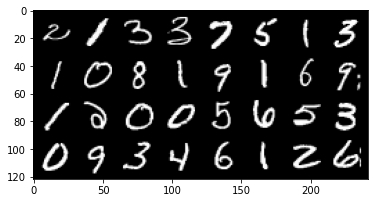

        2         1         3         3


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [7]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   100] loss: 1.361
[1,   200] loss: 0.497
[1,   300] loss: 0.397
[1,   400] loss: 0.331
[1,   500] loss: 0.359
[1,   600] loss: 0.338
[1,   700] loss: 0.317
[1,   800] loss: 0.280
[1,   900] loss: 0.310
[1,  1000] loss: 0.279
[1,  1100] loss: 0.269
[1,  1200] loss: 0.242
[1,  1300] loss: 0.219
[1,  1400] loss: 0.232
[1,  1500] loss: 0.213
[1,  1600] loss: 0.230
[1,  1700] loss: 0.187
[1,  1800] loss: 0.208


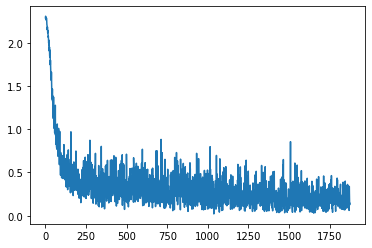

In [8]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


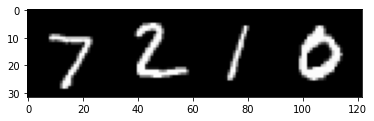

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [9]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [10]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [11]:
print("Current accuracy: %f" % accuracy(net, data['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current accuracy: 0.950083


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [12]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.9611 0.95 0.8964


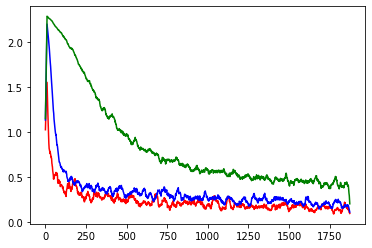

In [13]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

It seems to be that changing the momentum to a higher value from 0.9 reduces the final accuracy of the model, which suggests that a higher momentum value is causing the SGD to overshoot the local minimum of the function and thus, upon convergence, the accuracy is lower than with a smaller momentum value. Making the momentum slightly smaller at 0.85 actually improves the accuracy when the learning rate is fixed at 0.1 (compared to momentum 0.9 in the last cell), which could potentially be due to the model not overshooting as much as with 0.9 momentum, but still having sufficient momentum to converge faster. Using a much lower momentum of 0.5 had roughly the same performance of using momentum 0.85 in terms of accuracy, but in general, seems to have slightly higher loss than when using momentum 0.85.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.9061 15.35287857055664
0.9604 15.224540710449219
0.9636 15.284494638442993


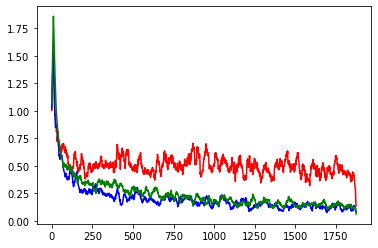

In [14]:
#TODO: Write your code here for experimenting with different values of momentum.
import time

net_1 = SimpleNet()
start_1 = time.time()
losses_1 = train(net_1, data['train'], lr=.1, momentum=0.95, verbose=0)
time_1 = time.time() - start_1
acc_1 = accuracy(net_1, data['test'])
plt.plot(smooth(losses_1,20), 'r-')

net_2 = SimpleNet()
start_2 = time.time()
losses_2 = train(net_2, data['train'], lr=.1, momentum=0.85, verbose=0)
time_2 = time.time() - start_2
acc_2 = accuracy(net_2, data['test'])
plt.plot(smooth(losses_2,20), 'b-')

net_3 = SimpleNet()
start_3 = time.time()
losses_3 = train(net_3, data['train'], lr=.1, momentum=0.5, verbose=0)
time_3 = time.time() - start_3
acc_3 = accuracy(net_3, data['test'])
plt.plot(smooth(losses_3,20), 'g-')

print(acc_1, time_1)
print(acc_2, time_2)
print(acc_3, time_3)

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

Our current model is very slightly overfitted to our training data, as is evident from the slight difference in accuracies between the predicitions our model makes on the training data and test data. Because the accuracy is lower with respect to the predictions made on our test data, it is evident that our model is more in tune with our training data specifically and hence has some inconsistencies when presented with new data, a product of overfitting. 

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

We tried decay values of 0.1, 0.01, and 0.001. As seen by the accuracies below, our model seems to perform best when decay is 0.001, both in terms of accuracy and time to convergence. This makes sense. Weight decay is used as a means of reducing overfitting by keeping the weights of layers in our model small. In this case, we identified a very slight amount of overfitting to our training data. As a result, we do not need much weight decay (or even none at all in the case of the values we have tried) to bump up the accuracy of our model with respect to test data. The increasing of weight decay negatively impacted our model due to the fact that they actually worked to keep our weights too small by proxy of optimization, resulting in underfitting. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Accuracy: 0.9681


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.7561 15.267642498016357
0.9092 15.282719373703003
0.9534 15.20804738998413


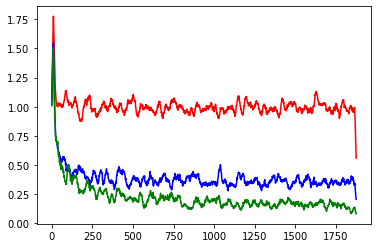

In [15]:
#TODO: Write your code here for experimenting with different weight decay
import time

acc_train = accuracy(net_2, data['train'])
print("Training Accuracy: " + str(acc_train))

net_4 = SimpleNet()
start_4 = time.time()
losses_4 = train(net_4, data['train'], lr=.1, momentum=.85, decay=.1, verbose=0)
time_4 = time.time() - start_4
acc_4 = accuracy(net_4, data['test'])
plt.plot(smooth(losses_4,20), 'r-')

net_5 = SimpleNet()
start_5 = time.time()
losses_5 = train(net_5, data['train'], lr=.1, momentum=.85, decay=.01, verbose=0)
time_5 = time.time() - start_5
acc_5 = accuracy(net_5, data['test'])
plt.plot(smooth(losses_5,20), 'b-')

net_6 = SimpleNet()
start_6 = time.time()
losses_6 = train(net_6, data['train'], lr=.1, momentum=.85, decay=.001, verbose=0)
time_6 = time.time() - start_6
acc_6 = accuracy(net_6, data['test'])
plt.plot(smooth(losses_6,20), 'g-')

print(acc_4, time_4)
print(acc_5, time_5)
print(acc_6, time_6)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

Our final model uses 3 fully connected layers, where the first one goes from the 28x28 input space to 256, the second goes from 256 to 128, and the final layer goes from 128 to the output classification of 10. Further, we chose to use a leaky RELU activation function for the first hidden layer of neurons,  and then regular RELU for the second. We were curious of how such a 'funnel' technique in architecture would impact our model. Specifically, since our output space is much smaller than our input space, we hypothesized that perhaps a gradual decrease in space at each layer of our neural network would help catch nuances in the data better than just one large step. 

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

We experimented with learning rate, momentum, and weight decay and tried three to four values for each. At the end, we settled on the parameter combination: LR = 0.01, M = 0.95, Weight Decay = 0.0001 as the best parameter set. Overall, there was not much overfitting or underfitting to be managed for due to the fact that our optimal weight decay was so small. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9597 16.597277402877808


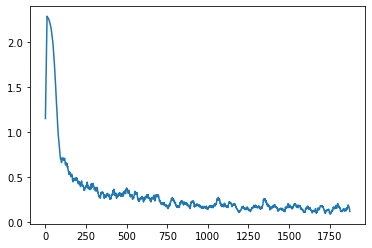

In [17]:
#TODO: Write your new model and experiments here

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Dialing in LR
# exp_net_1 = ExperiNet()
# exp_start_1 = time.time()
# exp_losses_1 = train(exp_net_1, data['train'], lr=.1, verbose=0)
# exp_time_1 = time.time() - exp_start_1
# exp_acc_1 = accuracy(exp_net_1, data['test'])
# plt.plot(smooth(exp_losses_1,20), 'r-')
# print(exp_acc_1, exp_time_1)

# exp_net_2 = ExperiNet()
# exp_start_2 = time.time()
# exp_losses_2 = train(exp_net_2, data['train'], lr=.01, verbose=0)
# exp_time_2 = time.time() - exp_start_2
# exp_acc_2 = accuracy(exp_net_2, data['test'])
# plt.plot(smooth(exp_losses_2,20), 'g-')
# print(exp_acc_2, exp_time_2)

# exp_net_3 = ExperiNet()
# exp_start_3 = time.time()
# exp_losses_3 = train(exp_net_3, data['train'], lr=.001, verbose=0)
# exp_time_3 = time.time() - exp_start_3
# exp_acc_3 = accuracy(exp_net_3, data['test'])
# plt.plot(smooth(exp_losses_3,20), 'b-')
# print(exp_acc_3, exp_time_3)

# Holding LR = 0.01 and testing momentum

# exp_net_4 = ExperiNet()
# exp_start_4 = time.time()
# exp_losses_4 = train(exp_net_4, data['train'], lr=.01, momentum = 0.95, verbose=0)
# exp_time_4 = time.time() - exp_start_4
# exp_acc_4 = accuracy(exp_net_4, data['test'])
# plt.plot(smooth(exp_losses_4,20), 'r-')
# print(exp_acc_4, exp_time_4)

# exp_net_5 = ExperiNet()
# exp_start_5 = time.time()
# exp_losses_5 = train(exp_net_5, data['train'], lr=.01, momentum = 0.85, verbose=0)
# exp_time_5 = time.time() - exp_start_5
# exp_acc_5 = accuracy(exp_net_5, data['test'])
# plt.plot(smooth(exp_losses_5,20), 'g-')
# print(exp_acc_5, exp_time_5)

# exp_net_6 = ExperiNet()
# exp_start_6 = time.time()
# exp_losses_6 = train(exp_net_6, data['train'], lr=.01, momentum = 0.75, verbose=0)
# exp_time_6 = time.time() - exp_start_6
# exp_acc_6 = accuracy(exp_net_6, data['test'])
# plt.plot(smooth(exp_losses_6,20), 'b-')
# print(exp_acc_6, exp_time_6)


# Holding LR = 0.01 and M = 0.95

# w_decay = [0.0001, 0.001, 0.01]
# for w in w_decay:
#     exp_net = ExperiNet()
#     s = time.time()
#     l = train(exp_net, data['train'], lr=0.01, momentum = 0.95, decay = w, verbose = 0)
#     t = time.time() - s
#     acc = accuracy(exp_net, data['test'])
#     plt.plot(smooth(l, 20))
#     print(acc, t)

# Final parameters: LR = 0.01, M = 0.95, Weight Decay = 0.0001
final_net = ExperiNet()
final_s = time.time()
final_l = train(final_net, data['train'], lr=0.01, momentum = 0.95, decay = 0.0001, verbose = 0)
final_t = time.time() - final_s
final_acc = accuracy(final_net, data['test'])
plt.plot(smooth(final_l, 20))
print(final_acc, final_t)

##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.